In [1]:
SEED = 27

In [2]:
import copy
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autocast, GradScaler
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import maxvit_t, MaxVit_T_Weights
from ema_pytorch import EMA

# import coral and corn losses
from coral_pytorch.losses import CornLoss
from coral_pytorch.losses import CoralLoss
from coral_pytorch.layers import CoralLayer
from coral_pytorch.dataset import label_to_levels, corn_label_from_logits, proba_to_label

In [ ]:
# Load tensors for training
X_train_tensor = torch.load('../data/train/X_train_data.pt')
y_train_tensor = torch.load('../data/train/y_train_data.pt')

levels_list = [label_to_levels(int(label.item() * 5), num_classes=6, dtype=torch.float32) for label in y_train_tensor.view(-1)]
coral_y_train_tensor = torch.stack(levels_list)

# Corn y_train tensor
corn_y_train_tensor = (y_train_tensor * 5).long().squeeze(-1)  # Convert to 0-5 range

X_val_tensor = torch.load('../data/valid/X_val_data.pt')
y_val_tensor = torch.load('../data/valid/y_val_data.pt')

# Coral y_val tensor
levels_list_val = [label_to_levels(int(label.item() * 5), num_classes=6, dtype=torch.float32) for label in y_val_tensor.view(-1)]
coral_y_val_tensor = torch.stack(levels_list_val)

# Corn y_val tensor
corn_y_val_tensor = (y_val_tensor * 5).long().squeeze(-1)  # Convert to 0-5 range

X_train_tensor.shape, coral_y_train_tensor.shape, corn_y_train_tensor.shape, X_val_tensor.shape, coral_y_val_tensor.shape, corn_y_val_tensor.shape

(torch.Size([1294, 3, 224, 224]),
 torch.Size([1294, 5]),
 torch.Size([1294]),
 torch.Size([133, 3, 224, 224]),
 torch.Size([133, 5]),
 torch.Size([133]))

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
# Create tensor dataset for data loader
Coral_train_dataset = TensorDataset(X_train_tensor, coral_y_train_tensor)
Corn_train_dataset = TensorDataset(X_train_tensor, corn_y_train_tensor)

Coral_train_dataset[:][0].shape, Coral_train_dataset[:][1].shape

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 5]))

In [7]:
Coral_train_dataset[:5][1]

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
Corn_train_dataset[:5][1]

tensor([5, 2, 1, 4, 0])

In [9]:
# Data augmentation pipeline.
augment = torch.nn.Sequential(
    K.RandomRotation(degrees=(-22.5, 22.5), p=0.5),
    K.RandomResizedCrop(size=(224, 224), scale=(0.7, 1), ratio=(0.9, 1.1), p= 0.6),
    K.RandomEqualize(p=0.6),
    K.RandomGaussianNoise(mean=0, std=0.075, p=0.33),
    K.RandomSaturation(saturation=(0.75, 1.25), p=0.5),
    K.RandomHue(hue=(-0.01, 0.01), p=0.8),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.7),
    K.RandomBrightness(brightness=(0.8, 1.1), p=0.7),
    K.RandomPerspective(distortion_scale=0.2, p=0.33),
    K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
def build_maxvit_t_coral():
    """
    Constructs and customizes a MaxViT-T model for Coral Loss.

    This function loads a pretrained MaxViT-T model using ImageNet-1K weights, applies selective freezing 
    and dropout adjustments, and modifies the final classification layer to Coral layer outputting num_classes - 1 values
    instead of the 1000 classes of ImageNet-1K.

    Parameters
    ----------
    None

    Returns
    -------
    model : torch.nn.Module
        A modified MaxViT-T model with:
        - Pretrained weights from ImageNet-1K.
        - Frozen parameters in the first block (`model.blocks[0]`).
        - Dropout rate set to 0.5 in all Dropout layers outside the frozen block.
        - Final classifier layer replaced with a Coral layer outputting num_classes - 1 values instead of the 1000 classes of ImageNet-1K.
    """

    weights = MaxVit_T_Weights.IMAGENET1K_V1
    model = maxvit_t(weights=weights)
    
    # Freeze the parameters of the first block
    for param in model.blocks[0].parameters():
        param.requires_grad = False
    
    # Set dropout rate to 0.5 in all Dropout layers except the first block which is frozen
    for module in model.blocks[1:].modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.5         

    # Modify the final layer to output a single value for classification
    in_features = model.classifier[-1].in_features # 512
    model.classifier[-1] = CoralLayer(in_features, 6)  # num_classes

    return model

def build_maxvit_t_corn():
    """
    Constructs and customizes a MaxViT-T model for Corn Loss.

    This function loads a pretrained MaxViT-T model using ImageNet-1K weights, applies selective freezing 
    and dropout adjustments, and modifies the final classification layer to output 5 values for Corn Loss
    instead of the 1000 classes of ImageNet-1K.
    Parameters
    ----------
    None

    Returns
    -------
    model : torch.nn.Module
        A modified MaxViT-T model with:
        - Pretrained weights from ImageNet-1K.
        - Frozen parameters in the first block (`model.blocks[0]`).
        - Dropout rate set to 0.5 in all Dropout layers outside the frozen block.
        - Final classifier layer replaced with a linear layer outputting 5 values instead of the 1000 classes of ImageNet-1K.
    """

    weights = MaxVit_T_Weights.IMAGENET1K_V1
    model = maxvit_t(weights=weights)
    
    # Freeze the parameters of the first block
    for param in model.blocks[0].parameters():
        param.requires_grad = False
    
    # Set dropout rate to 0.5 in all Dropout layers except the first block which is frozen
    for module in model.blocks[1:].modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.5         

    # Modify the final layer to output a single value for classification
    in_features = model.classifier[-1].in_features # 512
    model.classifier[-1] = nn.Linear(in_features, 5)  # num_classes - 1

    return model

In [ ]:
def train_model(model, train_dataset, X_tensor_val, y_tensor_val, loss_func, epochs=500, batch_size=32, learning_rate=5e-5, scheduler=False, scheduler_patience=50, early_stopping=True, early_stopping_patience=50, smooth=True, show=True, corn=False):
    """
    Train a PyTorch model using mixed precision, optional EMA smoothing, learning-rate scheduling, and early stopping.

    Parameters
    ----------
    model : torch.nn.Module
        The model to train. The model is moved to a device referenced by the global variable `device`.
    train_dataset : torch.utils.data.Dataset or torch.utils.data.TensorDataset
        Dataset used for training. Batches are drawn with a reproducible Generator seeded inside the function.
    X_tensor_val : torch.Tensor
        Validation feature tensor used for early-stopping evaluation. Sent to `device` when `early_stopping` is True.
    y_tensor_val : torch.Tensor
        Validation label tensor corresponding to `X_tensor_val`. Sent to `device` when `early_stopping` is True.
    loss_func : torch.nn.Module
        Loss function used for training and validation.
    epochs : int, optional
        Maximum number of training epochs. Default is 500.
    batch_size : int, optional
        Batch size for the training DataLoader. Default is 32.
    learning_rate : float, optional
        Initial learning rate passed to the AdamW optimizer. Default is 5e-5.
    scheduler : bool, optional
        If True, a StepLR scheduler is created and stepped each epoch. Default is False.
    scheduler_patience : int, optional
        Step size (in epochs) passed to StepLR when `scheduler` is True. Default is 50.
    early_stopping : bool, optional
        If True, validation loss is monitored and training may stop early when no improvement is observed. Default is True.
    early_stopping_patience : int, optional
        Number of consecutive epochs without improvement on the validation loss required to trigger early stopping. Default is 50.
    smooth : bool, optional
        If True, an EMA wrapper is used to maintain a smoothed copy of model weights during training. Default is True.
    show : bool, optional
        If True, periodic progress and validation metrics are printed to stdout. Default is True.

    Returns
    -------
    model : torch.nn.Module
        The trained model. If early stopping was used, the function restores and returns the state corresponding to the best observed validation loss.

    Behavior and Implementation Details
    -----------------------------------
    - The function seeds PyTorch (`torch.manual_seed(27)`) and the DataLoader generator for reproducibility.
    - The model is moved to the global `device`. When `early_stopping` is enabled, validation tensors are moved to `device`.
    - Optimizer: AdamW with the provided `learning_rate` and a small weight decay (1e-8).
    - Loss: the provided `loss_func` is used for both training and validation.
    - Mixed precision: training uses AMP via `autocast` and a `GradScaler` for stable FP16 updates.
    - EMA smoothing: when `smooth` is True, an `EMA` instance is created and updated after each optimizer step; evaluation uses the EMA copy if available.
    - Data loading: DataLoader is created with `shuffle=True`, a deterministic `Generator` seed, and `pin_memory=True`.
    - Augmentation: each training batch and the validation input passed to the evaluation step are transformed with an `augment` function expected to exist in the calling scope.
    - Scheduler: if `scheduler` is True, a StepLR scheduler with `step_size=scheduler_patience` and `gamma=0.85` is stepped each epoch.
    - Early stopping: when enabled, the function evaluates the model (or EMA model) on the validation tensors each epoch, tracks the best validation loss, saves the best model state_dict, and stops training if no improvement is seen for `early_stopping_patience` consecutive epochs; on early stop the best state is restored before returning the model.

    Notes
    -----
    - The function assumes the existence of the following names in the surrounding scope: `device`, `augment`, `EMA`, and relevant imports for `torch`, `optim`, `nn`, `GradScaler`, and `autocast`.
    - The final returned model is the model with parameters restored to the best validation snapshot if early stopping occurred, otherwise it is the last trained state.
    - The function prints periodic training statistics when `show` is True; printing frequency is every 10 epochs in the provided implementation.
    """

    # Seed for reproducibility
    torch.manual_seed(SEED)

    # Move model and validation tensors to device
    model = model.to(device)
    if early_stopping:
        X_tensor_val = X_tensor_val.to(device)
        y_tensor_val = y_tensor_val.to(device)

    # Define optimizer, loss function, and scaler for mixed precision
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-8            
    )

    criterion = loss_func

    scaler = GradScaler()

    # EMA smoothing
    if smooth:
        ema = EMA(
            model,
            beta=0.9999,
            update_after_step=0,
            update_every=1
        )

    # Learning rate scheduler
    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=scheduler_patience, 
                                            gamma=0.85)
    # Early stopping variables
    if early_stopping:
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model = None

    # DataLoader with reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    # Create DataLoader for training
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        pin_memory=True
    )

    # Training loop
    for epoch in range(epochs):

        if show:
            total_loss = 0.0

        # Set model to training mode
        model.train()

        # load batches
        for x_batch, y_batch in train_loader:

            # Apply augmentation
            x_batch = augment(x_batch)
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast(device_type=device.type):
                outputs = model(x_batch)
                outputs = outputs.view(outputs.size(0), -1)
                loss = criterion(outputs, y_batch)

            # Accumulate loss for reporting
            if show:
                total_loss += loss.item()

            # Backward pass and optimization step with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # EMA update
            if smooth:
                ema.update()

        # Step the learning rate scheduler
        if scheduler:
            step_lr.step()
        
        # Evaluate the EMA model if smoothing is enabled
        model_eval = ema.ema_model if smooth else model

        # Early stopping evaluation
        if early_stopping:

            # Set model to evaluation mode
            model_eval.eval()

            # Set inference mode for model evaluation
            with torch.inference_mode():
                val_outputs = model_eval(X_tensor_val)
                val_outputs = val_outputs.view(val_outputs.size(0), -1)
                val_loss = criterion(val_outputs, y_tensor_val)

            # Check for improvement
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                epochs_without_improvement = 0
                best_model = model_eval.state_dict()
            else:
                epochs_without_improvement += 1

                # Check for early stopping condition
                if epochs_without_improvement >= early_stopping_patience:
                    if show:
                        print(f'No improvement observed in {early_stopping_patience} epochs. Stopping training.')

                    # Restore the model state with the best validation loss
                    model.load_state_dict(best_model)
                    return model

        # Print training progress
        if show and ((epoch + 1) % 10 == 0 or epoch == 0):
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if early_stopping:
                print(f'Best validation loss:{best_val_loss:.4f}')
                print(f'Current validation loss:{val_loss.item():.4f}')
                print("-" * 30)

    # If early stopping was used and it didn't trigger return the model with the best validation loss anyway
    if early_stopping and best_model:
        model.load_state_dict(best_model)

    return model


In [5]:
# Check GPU memory usage for training
print(torch.cuda.memory_allocated())

0


In [13]:
# Training
Coral_model = build_maxvit_t_coral()
Coral_model = train_model(Coral_model, Coral_train_dataset, X_val_tensor, coral_y_val_tensor, loss_func=CoralLoss())

Epoch [1/500], Loss: 2.5830
Best validation loss:2.3896
Current validation loss:2.3896
------------------------------
Epoch [10/500], Loss: 1.6813
Best validation loss:2.0559
Current validation loss:2.0669
------------------------------
Epoch [20/500], Loss: 1.5204
Best validation loss:1.8630
Current validation loss:1.8630
------------------------------
Epoch [30/500], Loss: 1.3428
Best validation loss:1.8549
Current validation loss:2.0035
------------------------------
Epoch [40/500], Loss: 1.3300
Best validation loss:1.7037
Current validation loss:1.7037
------------------------------
Epoch [50/500], Loss: 1.1442
Best validation loss:1.6986
Current validation loss:1.6986
------------------------------
Epoch [60/500], Loss: 1.1404
Best validation loss:1.5902
Current validation loss:1.7666
------------------------------
Epoch [70/500], Loss: 1.0116
Best validation loss:1.5902
Current validation loss:1.7018
------------------------------
Epoch [80/500], Loss: 0.9944
Best validation loss

In [ ]:
# Save the trained model state dictionary
torch.save(Coral_model.state_dict(), '../models/Coral_loss_maxvit_t_model_state_dict.pth')

In [13]:
Corn_model = build_maxvit_t_corn()
Corn_model = train_model(Corn_model, Corn_train_dataset, X_val_tensor, corn_y_val_tensor, loss_func=CornLoss(num_classes=6), corn=True)

Epoch [1/500], Loss: 0.5618
Best validation loss:0.5876
Current validation loss:0.5876
------------------------------
Epoch [10/500], Loss: 0.2403
Best validation loss:0.2743
Current validation loss:0.2743
------------------------------
Epoch [20/500], Loss: 0.1022
Best validation loss:0.2500
Current validation loss:0.2560
------------------------------
Epoch [30/500], Loss: 0.0563
Best validation loss:0.2500
Current validation loss:0.2851
------------------------------
Epoch [40/500], Loss: 0.0334
Best validation loss:0.2500
Current validation loss:0.3145
------------------------------
Epoch [50/500], Loss: 0.0177
Best validation loss:0.2500
Current validation loss:0.3585
------------------------------
Epoch [60/500], Loss: 0.0161
Best validation loss:0.2500
Current validation loss:0.3856
------------------------------
No improvement observed in 50 epochs. Stopping training.


In [ ]:
torch.save(Corn_model.state_dict(), '../models/Corn_loss_maxvit_t_model_state_dict.pth')

In [6]:
Coral_model = build_maxvit_t_coral()
Coral_model.load_state_dict(torch.load('../models/Coral_loss_maxvit_t_model_state_dict.pth'))
Coral_model = Coral_model.to(device)

Corn_model = build_maxvit_t_corn()
Corn_model.load_state_dict(torch.load('../models/Corn_loss_maxvit_t_model_state_dict.pth'))
Corn_model = Corn_model.to(device)

In [ ]:
# Normalization, the saved tensors are not normalized yet
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def evaluate_model(y_eval, y_pred):
    """
    Evaluates classification model performance using rescaled labels, bootstrap metrics, and visual diagnostics.

    This function compares predicted labels to true labels by rescaling and rounding normalized values.
    It computes accuracy, mean absolute error (MAE), mean absolute percentage error (MAPE), and quadratic Cohen's Kappa
    using bootstrap resampling. It also visualizes the confusion matrix to assess prediction quality.

    Parameters
    ----------
    y_eval : torch.Tensor
        Ground truth labels as a 1D tensor, normalized in the range [0, 1].

    y_pred : torch.Tensor
        Predicted labels as a 1D tensor, also normalized in the range [0, 1].

    Returns
    -------
    None
        The function prints evaluation metrics and displays visualizations. It does not return any value.

    Notes
    -----
    - Labels are rescaled to the original range [0-5] using: `np.round(value * 5)`.
    - Accuracy is computed as the proportion of exact matches between predicted and true labels.
    - Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) quantify prediction deviation.
    - Quadratic Cohen's Kappa measures agreement between predicted and true labels, accounting for ordinal structure.
    - Bootstrap resampling (10,000 samples) estimates the mean, standard deviation, and 95% confidence intervals for each metric.
    - A confusion matrix heatmap is displayed to visualize prediction distribution across classes.

    Visualization
    -------------
    - Confusion matrix: heatmap with true labels on the y-axis and predicted labels on the x-axis.
    - Mean Absolute Error distribution plot.
    """
    # Rescale and round labels to original range [0-5]
    y_eval = y_eval.detach().cpu().numpy()
    y_eval = np.clip(np.round(y_eval * 5)).astype(int)  + 1 # Avoid 0 division

    y_pred = y_pred.detach().cpu().numpy() + 1

    # Bootstrap
    n_samples = 10000
    rng = np.random.default_rng(seed=SEED)
    accuracies = []
    maes = []
    mapes = []
    kappa_scores = []
  
    for _ in range(n_samples):
        indexes = rng.choice(np.arange(len(y_eval)), size=len(y_eval), replace=True)
        y_pred_sample = y_pred[indexes]
        y_eval_sample = y_eval[indexes]
        accuracies.append(np.mean(y_pred_sample == y_eval_sample))
        maes.append(np.mean(np.abs(y_eval_sample - y_pred_sample)))
        mapes.append(np.mean(np.abs(y_pred_sample - y_eval_sample) / (y_eval_sample)) * 100)
        kappa_scores.append(cohen_kappa_score(y_eval_sample, y_pred_sample, weights='quadratic'))
    
    # Bootstrap results
    print(f'Bootstrap results: mean ± std | 95% Confidence Interval over {n_samples} samples')
    print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f} | CI: [{np.percentile(accuracies, 2.5):.2f} - {np.percentile(accuracies, 97.5):.2f}]')
    print(f'Mean Absolute Error: {np.mean(maes):.2f} ± {np.std(maes):.2f} | CI: [{np.percentile(maes, 2.5):.2f} - {np.percentile(maes, 97.5):.2f}]')
    print(f'Mean Absolute Percentage Error: {np.mean(mapes):.2f} ± {np.std(mapes):.2f} | CI: [{np.percentile(mapes, 2.5):.2f} - {np.percentile(mapes, 97.5):.2f}]')
    print(f'Quadratic Cohen\'s Kappa: {np.mean(kappa_scores):.2f} ± {np.std(kappa_scores):.2f} | CI: [{np.percentile(kappa_scores, 2.5):.2f} - {np.percentile(kappa_scores, 97.5):.2f}]')

    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    #error = y_eval - logits_pred
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=ax[0])
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Confusion Matrix')   
    sns.histplot(maes, ax=ax[1], color='navy', alpha=0.7, bins=15, kde=True)
    ax[1].axvline(x=np.mean(maes), color='red', linestyle='--', label='Mean')
    ax[1].axvline(x=np.percentile(maes, 2.5), color='green', linestyle='--', label='CI 95%')
    ax[1].axvline(x=np.percentile(maes, 97.5), color='green', linestyle='--')
    ax[1].text(np.percentile(maes, 2.5) - np.std(mapes) * 0.02, len(maes) * 0.2, '2.5%', color='green')
    ax[1].text(np.percentile(maes, 97.5) + np.std(mapes) * 0.0025, len(maes) * 0.2, '97.5%', color='green')
    ax[1].set_title('Bootstrap Mean Absolute Error Distribution')
    ax[1].legend()
    
    plt.show()

In [67]:
# Test tensors
X_test_tensor = torch.load('../data/test/X_test_data.pt', map_location=device)
y_test_tensor = torch.load('../data/test/y_test_data.pt', map_location=device)

# Normalize test data
X_test_tensor = normalize(X_test_tensor)
y_test_tensor = y_test_tensor.squeeze(1)
print(X_test_tensor.shape, y_test_tensor.shape)

# Get model test predictions
with torch.inference_mode():
    Coral_model.eval()
    Corn_model.eval()
    logits_test_Coral = Coral_model(X_test_tensor)
    logits_test_Coral = logits_test_Coral.view(logits_test_Coral.size(0), -1)

    logits_test_Corn = Corn_model(X_test_tensor)
    logits_test_Corn = logits_test_Corn.view(logits_test_Corn.size(0), -1)

    pred_test_Coral = proba_to_label(logits_test_Coral.sigmoid())
    pred_test_Corn = corn_label_from_logits(logits_test_Corn)

torch.Size([67, 3, 224, 224]) torch.Size([67])


In [68]:
pred_test_Coral.unique(), pred_test_Corn.unique()

(tensor([0, 1, 2, 3, 4, 5], device='cuda:0'),
 tensor([0, 1, 2, 3, 4, 5], device='cuda:0'))

Coral Loss Model Evaluation:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.70 ± 0.06 | CI: [0.60 - 0.81]
Mean Absolute Error: 0.33 ± 0.06 | CI: [0.21 - 0.46]
Mean Absolute Percentage Error: 11.18 ± 2.24 | CI: [7.01 - 15.77]
Quadratic Cohen's Kappa: 0.93 ± 0.02 | CI: [0.88 - 0.96]


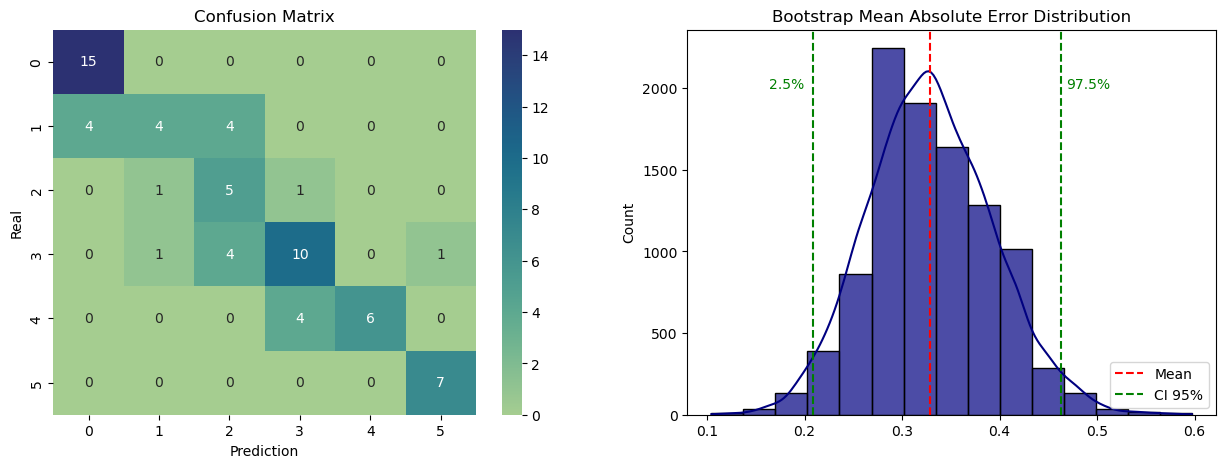

------------------------------
Corn Loss Model Evaluation:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.72 ± 0.06 | CI: [0.61 - 0.82]
Mean Absolute Error: 0.34 ± 0.07 | CI: [0.21 - 0.49]
Mean Absolute Percentage Error: 12.60 ± 2.99 | CI: [7.11 - 18.81]
Quadratic Cohen's Kappa: 0.91 ± 0.03 | CI: [0.85 - 0.96]


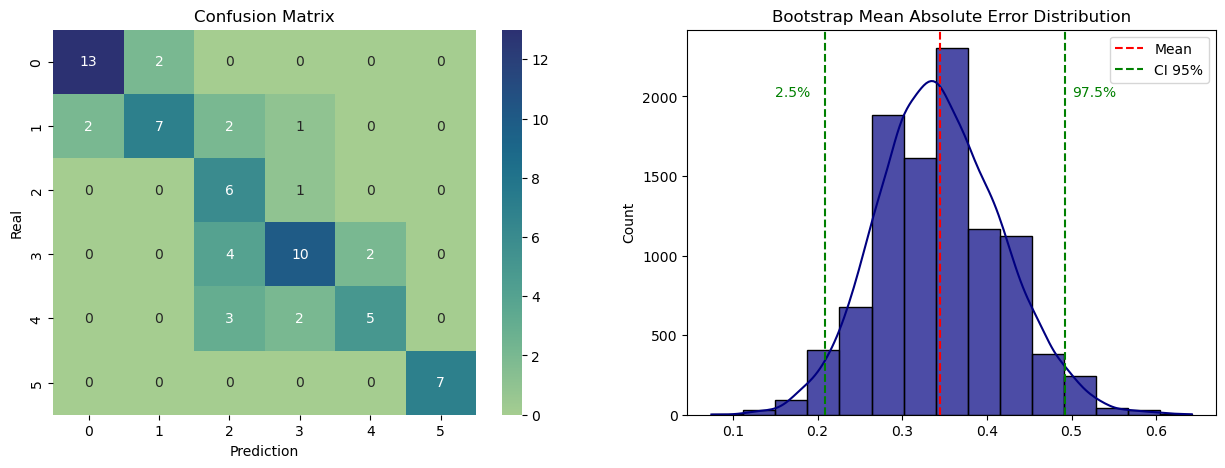

In [69]:
# Evaluate model performance on test set
print("Coral Loss Model Evaluation:")
print("-" * 30)
evaluate_model(y_eval=y_test_tensor,y_pred=pred_test_Coral)
print("-" * 30)
print("Corn Loss Model Evaluation:")
print("-" * 30)
evaluate_model(y_eval=y_test_tensor, y_pred=pred_test_Corn)

# Clear memory
#del X_test_tensor, y_test_tensor, logits_test_Coral, logits_test_Corn
torch.cuda.empty_cache()

Coral Loss Model Evaluation:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.64 ± 0.04 | CI: [0.56 - 0.72]
Mean Absolute Error: 0.41 ± 0.05 | CI: [0.32 - 0.52]
Mean Absolute Percentage Error: 15.28 ± 2.34 | CI: [11.00 - 20.05]
Quadratic Cohen's Kappa: 0.89 ± 0.02 | CI: [0.85 - 0.93]


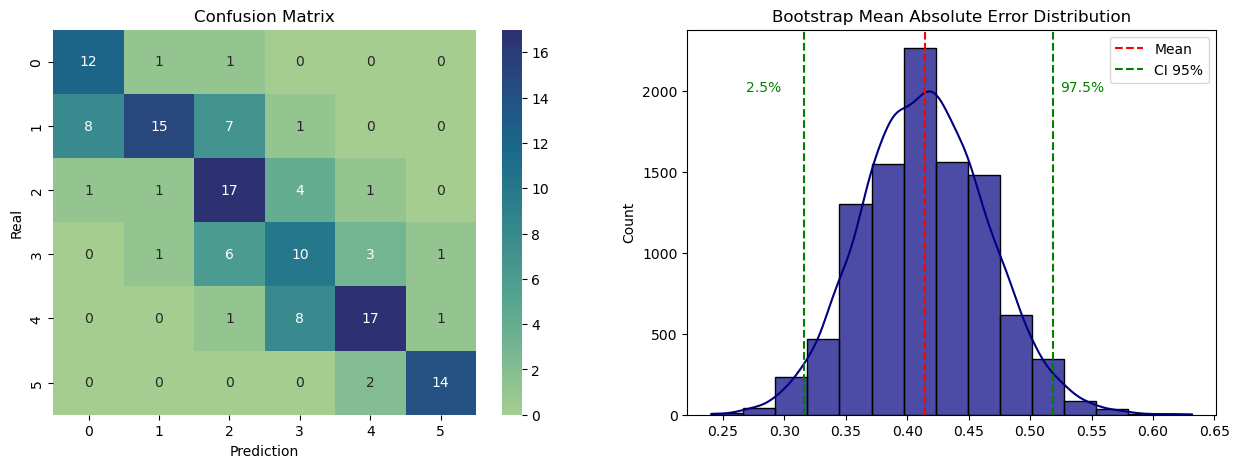

------------------------------
Corn Loss Model Evaluation:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.74 ± 0.04 | CI: [0.67 - 0.82]
Mean Absolute Error: 0.31 ± 0.05 | CI: [0.22 - 0.41]
Mean Absolute Percentage Error: 12.52 ± 2.41 | CI: [8.12 - 17.57]
Quadratic Cohen's Kappa: 0.92 ± 0.02 | CI: [0.88 - 0.95]


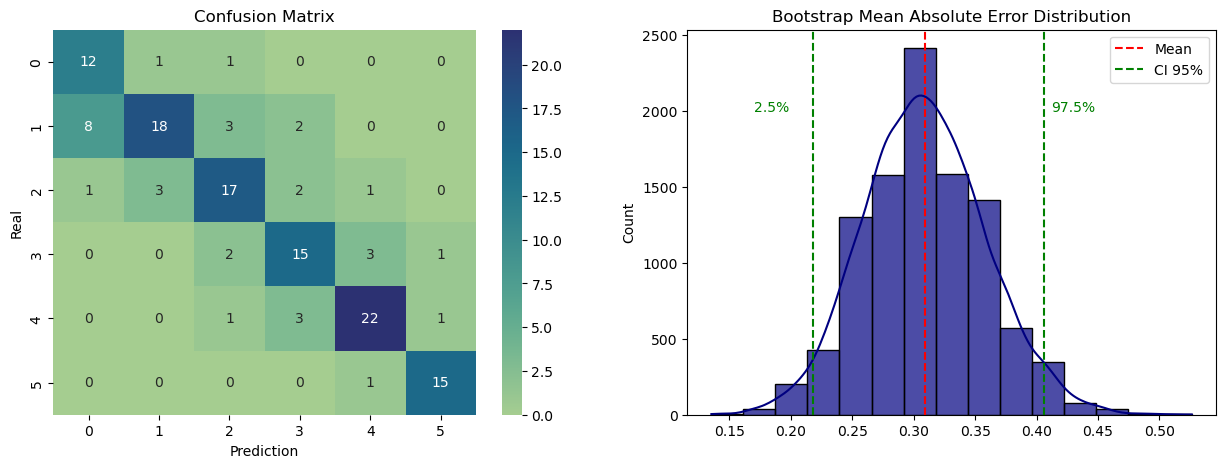

In [70]:
# Load validation tensors
X_val_tensor = torch.load('../data/valid/X_val_data.pt', map_location=device)
y_val_tensor = torch.load('../data/valid/y_val_data.pt', map_location=device)
y_val_tensor = y_val_tensor.squeeze(1)


X_val_tensor = normalize(X_val_tensor)

with torch.inference_mode():    
    Coral_model.eval()
    Corn_model.eval()
    logits_val_Coral = Coral_model(X_val_tensor)
    logits_val_Coral = logits_val_Coral.view(logits_val_Coral.size(0), -1)

    logits_val_Corn = Corn_model(X_val_tensor)
    logits_val_Corn = logits_val_Corn.view(logits_val_Corn.size(0), -1)

    pred_val_Coral = proba_to_label(logits_val_Coral.sigmoid())
    pred_val_Corn = corn_label_from_logits(logits_val_Corn)

print("Coral Loss Model Evaluation:")
print("-" * 30)
evaluate_model(y_eval=y_val_tensor, y_pred=pred_val_Coral)
print("-" * 30)
print("Corn Loss Model Evaluation:")
print("-" * 30)
evaluate_model(y_eval=y_val_tensor, y_pred=pred_val_Corn)

# Clear memory
del X_val_tensor, y_val_tensor, logits_val_Coral, logits_val_Corn
torch.cuda.empty_cache()

Coral Loss Model Evaluation on Training Set:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 1.00 ± 0.00 | CI: [0.99 - 1.00]
Mean Absolute Error: 0.00 ± 0.00 | CI: [0.00 - 0.01]
Mean Absolute Percentage Error: 0.08 ± 0.03 | CI: [0.02 - 0.15]
Quadratic Cohen's Kappa: 1.00 ± 0.00 | CI: [1.00 - 1.00]


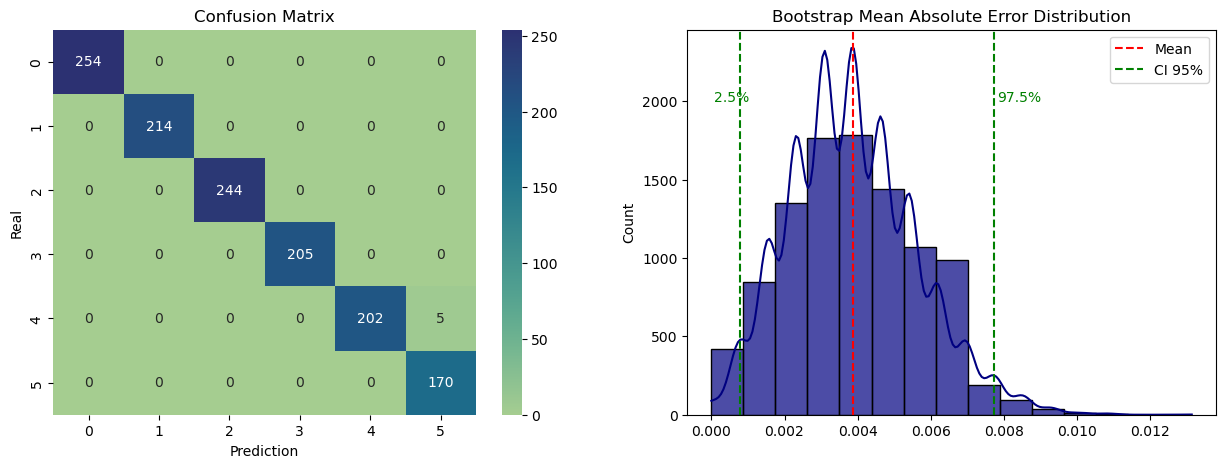

------------------------------
Corn Loss Model Evaluation on Training Set:
------------------------------
Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 1.00 ± 0.00 | CI: [1.00 - 1.00]
Mean Absolute Error: 0.00 ± 0.00 | CI: [0.00 - 0.00]
Mean Absolute Percentage Error: 0.00 ± 0.00 | CI: [0.00 - 0.00]
Quadratic Cohen's Kappa: 1.00 ± 0.00 | CI: [1.00 - 1.00]


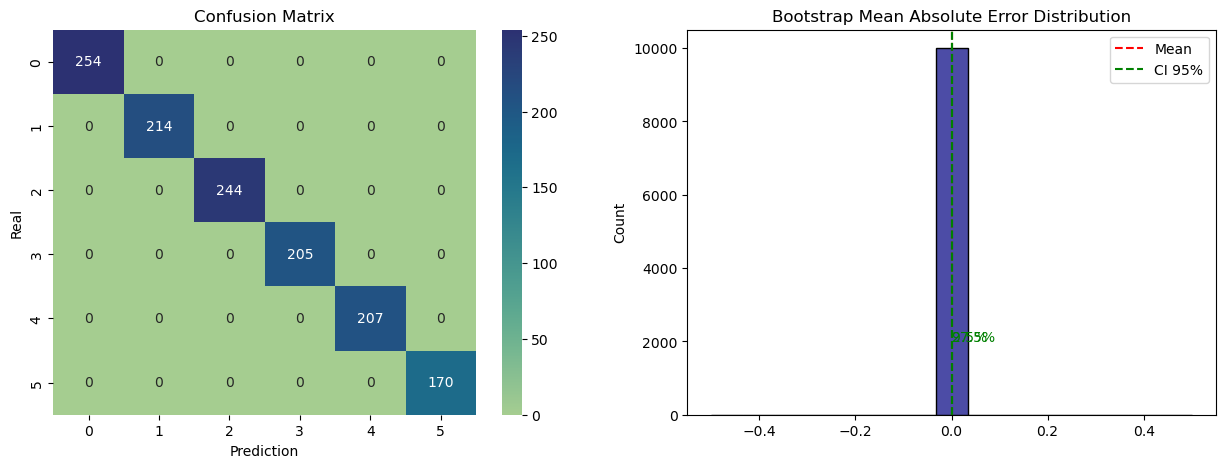

In [71]:
# Normalize training data
X_train_tensor = torch.load('../data/train/X_train_data.pt', map_location=device)
y_train_tensor = torch.load('../data/train/y_train_data.pt', map_location=device)
y_train_tensor = y_train_tensor.squeeze(1)

X_train_tensor = normalize(X_train_tensor)

# Create DataLoader for training data since it does not fit in memory all at once
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(Train_dataset, batch_size=128, shuffle=False)

# Get model training predictions in batches
logits_train_coral = torch.tensor([]).to(device)
logits_train_corn = torch.tensor([]).to(device)

for x_batch, y_batch in train_loader:
    with torch.inference_mode():
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits_train_batch_coral = Coral_model(x_batch)
        logits_train_batch_coral = logits_train_batch_coral.view(logits_train_batch_coral.size(0), -1)

        logits_train_batch_corn = Corn_model(x_batch)
        logits_train_batch_corn = logits_train_batch_corn.view(logits_train_batch_corn.size(0), -1)

        logits_train_coral = torch.cat((logits_train_coral, logits_train_batch_coral), dim=0)
        logits_train_corn = torch.cat((logits_train_corn, logits_train_batch_corn), dim=0)

pred_train_coral = proba_to_label(logits_train_coral.sigmoid())
pred_train_corn = corn_label_from_logits(logits_train_corn)

print("Coral Loss Model Evaluation on Training Set:")
print("-" * 30)
evaluate_model(y_eval=y_train_tensor, y_pred=pred_train_coral)
print("-" * 30)
print("Corn Loss Model Evaluation on Training Set:")
print("-" * 30)
evaluate_model(y_eval=y_train_tensor, y_pred=pred_train_corn)

# Clear memory even if is not needed anymore in this notebook, this pc is still used on other tasks
del X_train_tensor, y_train_tensor, logits_train_coral, logits_train_corn
torch.cuda.empty_cache()